# Find Best Electrode Depths

Uses `.npy.gz` data files to generate figures summarizing all electrode depths for each animal.

### Before Running:

- Check the `mmsenv` kernel has been selected (Top right of this page > "Python (...)" > Select Kernel)
- Set up constants and parameters in this Jupyter Notebook file first (see below for specific parameters)
- Delete all files in `/temp-depthsort`, `/output-depthsort-csv`, `/sortings`, and move existing figures to a subfolder in `/output-depthsort`
- For tidiness, move existing `slurm*.out` files into `/slurms`
- Relevant `.npy.gz` files should have already been generated by `marshmountainsort.ipynb`
- `sheet_name` in `excel_name` should contain all .npy.gz files' names and turn depths.
    - Generate the most updated sheet template in `findnewtxt.ipynb > Make Turn Depth .XLSX`, and fill in the turn depths manually

### Running Code:

You can run this code either locally or on the HPC (High Performance Computing cluster). Running locally is convenient for quick testing/debugging, but can only process one animal/genotype at a time (single-threaded program) and crashes for huge files. All batch analysis pipelines should be run on the HPC, which allows code to be run in parallel and massively reduces computation time. You may also run analysis of single files on the HPC, but the speedup is marginal and errors are more inconvenient to debug.

- Local:
    - `animal_id` and `genotype_idx` (0 for WT/Bl6, 1 for Exp) should uniquely identify a recording series. For instance, WT mouse #1133 has animal_id=1133 and genotype_idx=0
        - Overlapping IDs with different genotypes are OK though not best practice
    - Set `GENERATEALL=False`, which will ignore the HPC code
    - (Optional) If you are just debugging/testing, set `TRUNCATE=True` and `TRUNCATE_SKIP` to any whole number >=1. **Warning:** This may break code functionality. NEVER save output files from a truncated run (delete them asap if you do)
    - Skip the cells immediately below that contain `!jupyter` commands and run all cells starting from the constants-defining cell.
- HPC
    - Check that all `animals_genotypes` contains all animal and genotype combinations that have .npy.gz files created
        - If a combination is not included, it will be ignored, which can be useful to ignore bad recording series.
    - Set `GENERATEALL=True`, which will ignore animal_id genotype_idx and genotype, using the HPC code and animals_genotypes instead
    - Reset the file counter. This is used to track which animal/genotype combinations were sent to the HPC
        - Run this file up to and including the cell marked `# RUN BEFORE GENERATEALL`, skipping the `!jupyter` cells below
    - Set `n_generateall` to the number of animal/genotype combinations you have, plus 3 just for safety
    - Then run that cell `### All Animal/Genotype Combinations ###`

### Where is the output?

- `output-depthsort-csv` has individual extracted spikes for every unit, organized into .CSV
- `output-depthsort` has summary figures for every animal/genotype combination, which can be used to diagnose bad recordings or recording series
- `slurm*.out` files are dumped into the MarshMountainSort directory and are helpful for debugging and checking for errors
- **MOST IMPORANTLY:** `sortings` contains SpikeInterface recording and sorting objects that can be used for downstream analysis (`marshmakestatsandfigs.ipynb`, or your own crafted pipeline)

## Push Program to HPC

In [30]:
### Single Animal/Genotype Combination ###
# Save the notebook as a .py, and run on HPC
!jupyter nbconvert --to script marshfindbestdepths.ipynb --TagRemovePreprocessor.remove_cell_tags='{"note"}' --output-dir ./pys
!sbatch --mem=20G -t 24:00:00 /mnt/isilon/marsh_single_unit/MarshMountainSort/MarshFindBestDepths.sh
!echo "COMPLETE"

[NbConvertApp] Converting notebook marshfindbestdepths.ipynb to script
[NbConvertApp] Writing 23889 bytes to pys/marshfindbestdepths.py
Submitted batch job 23470526
COMPLETE


In [11]:
### All Animal/Genotype Combinations ###
# Save the notebook as a .py, and run on HPC
n_generateall = 20  # Number of animals/genotypes

for i in range(n_generateall):
    !jupyter nbconvert --to script marshfindbestdepths.ipynb --TagRemovePreprocessor.remove_cell_tags='{"note"}' --output-dir ./pys
    !sbatch --mem=20G -t 24:00:00 /mnt/isilon/marsh_single_unit/MarshMountainSort/MarshFindBestDepths.sh
    !sleep 30

[NbConvertApp] Converting notebook marshfindbestdepths.ipynb to script
[NbConvertApp] Writing 23915 bytes to pys/marshfindbestdepths.py
Submitted batch job 23428192
[NbConvertApp] Converting notebook marshfindbestdepths.ipynb to script
[NbConvertApp] Writing 23915 bytes to pys/marshfindbestdepths.py
Submitted batch job 23428245
[NbConvertApp] Converting notebook marshfindbestdepths.ipynb to script
[NbConvertApp] Writing 23915 bytes to pys/marshfindbestdepths.py
Submitted batch job 23428308
[NbConvertApp] Converting notebook marshfindbestdepths.ipynb to script
[NbConvertApp] Writing 23915 bytes to pys/marshfindbestdepths.py
Submitted batch job 23428372
[NbConvertApp] Converting notebook marshfindbestdepths.ipynb to script
[NbConvertApp] Writing 23915 bytes to pys/marshfindbestdepths.py
Submitted batch job 23428440
[NbConvertApp] Converting notebook marshfindbestdepths.ipynb to script
[NbConvertApp] Writing 23915 bytes to pys/marshfindbestdepths.py
Submitted batch job 23428493
[NbConvert

In [22]:
# Define Constants
animal_id = 1133
genotype_idx = 0
genotype = ['WT', 'Exp'][genotype_idx]

animals_genotypes = [[1133, 0],
                     [1176, 0],
                     [1177, 0],
                     [1178, 0],
                     [1185, 1],
                     [1203, 0],
                     [1211, 0],
                     [1214, 0],
                     [1225, 0],
                     [1226, 0],
                     [1227, 0],
                     [1231, 0],
                     [1233, 0],
                     [1234, 0],
                     [1236, 1],
                     [1238, 1],
                     [1244, 0],
                     [1269, 1],
                     [766, 0],
                    ]
genotypes = ['WT', 'Exp']
genotypes_aliases = [['Bl6'], ['EXP']]
print(f"{len(animals_genotypes)} animals/genotypes total")

ncol = 16 # Number of channels in full recording, not including time column
ncol_tet = 4 # Number of channels in 1 tetrode
nheader = 12 # Number of lines in Dwave block header
f_s = 25000 # Hz

freq_min = 400 # Hz, for preprocessing bandpass low cutoff
freq_max = 8064 # Hz, for preprocessing bandpass high cutoff

waveform_extraction_window = [2.0, 4.0]

GENERATEALL = False
TRUNCATE = False # Extract spikes from a subset of depths. SHOULD BE FALSE WHEN RUNNING FINAL
TRUNCATE_SKIP = 10 # Get every nth file
MOTIONCORR = False # Not currently used, makes sorting worse
SAVESORT = True
SAVEFIGS = True
SAVECSV = True

19 animals/genotypes total


In [23]:
import glob
import shutil
import os
import csv
import gzip
from pathlib import Path, PurePath
import datetime
import numba
import pickle
import pandas as pd
from warnings import warn

import pkg_resources
pkg_resources.require('matplotlib==3.8.3')
import matplotlib.pyplot as plt
import numpy as np
import probeinterface as pi
from probeinterface.plotting import plot_probe
import tempfile
from tempfile import TemporaryDirectory
from textwrap import wrap

import mountainsort5 as ms5
from mountainsort5.util import create_cached_recording
import spikeinterface.core as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
# import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
# import spikeinterface.qualitymetrics as sqm
# import spikeinterface.exporters as sexp
# import spikeinterface.comparison as scmp
# import spikeinterface.curation as scur
import spikeinterface.sortingcomponents as sc
# from spikeinterface.sortingcomponents.motion_interpolation import 
import spikeinterface.widgets as sw

## Define Constants

Unless you're adding new functionality or renaming files (not recommended) this shouldn't need to be modified.

In [24]:
base_folder_path = Path(f'/mnt/isilon/marsh_single_unit/MarshMountainSort')
binary_folder = 'bins'
output_folder = 'output-depthsort'
output_csv_folder = 'output-depthsort-csv'
temp_folder = 'temp-depthsort'
sort_folder = 'sortings'

tetrode_names = ['ca3', 'ca1s', 'ca1o']
filecount_name = 'filecount-depths.pk'
excel_name = 'fileturndepths.xlsx'
sheet_name = '08-07-2024'
title_name = 'MarshFindBestDepths_title.txt'

bin_folder_path = base_folder_path / binary_folder
output_folder_path = base_folder_path / output_folder
output_csv_folder_path = base_folder_path / output_csv_folder
temp_folder_path = base_folder_path / temp_folder
sort_folder_path = base_folder_path / sort_folder

print("="*110)
with open(base_folder_path / title_name, 'r') as f:
    print(f.read())
print("="*110)

# print(txt_folder_path)
print(bin_folder_path)
print(output_folder_path)
print(output_csv_folder_path)
print(temp_folder_path)
print(sort_folder_path)

  __  __                _       _____ _           _   ____            _     ____             _   _         
 |  \/  | __ _ _ __ ___| |__   |  ___(_)_ __   __| | | __ )  ___  ___| |_  |  _ \  ___ _ __ | |_| |__  ___ 
 | |\/| |/ _` | '__/ __| '_ \  | |_  | | '_ \ / _` | |  _ \ / _ \/ __| __| | | | |/ _ \ '_ \| __| '_ \/ __|
 | |  | | (_| | |  \__ \ | | | |  _| | | | | | (_| | | |_) |  __/\__ \ |_  | |_| |  __/ |_) | |_| | | \__ \
 |_|  |_|\__,_|_|  |___/_| |_| |_|   |_|_| |_|\__,_| |____/ \___||___/\__| |____/ \___| .__/ \__|_| |_|___/
                                                                                      |_|                  

/mnt/isilon/marsh_single_unit/MarshMountainSort/bins
/mnt/isilon/marsh_single_unit/MarshMountainSort/output-depthsort
/mnt/isilon/marsh_single_unit/MarshMountainSort/output-depthsort-csv
/mnt/isilon/marsh_single_unit/MarshMountainSort/temp-depthsort
/mnt/isilon/marsh_single_unit/MarshMountainSort/sortings


In [25]:
fcount_file_path = base_folder_path / filecount_name
print(f'Path for filecount:\n\t{fcount_file_path}')

def reset_filecount():
    with open(fcount_file_path, 'wb') as file:
        pickle.dump(0, file, protocol=pickle.HIGHEST_PROTOCOL)

def step_filecount():
    with open(fcount_file_path, 'rb') as file:
        out = pickle.load(file)
    out += 1
    with open(fcount_file_path, 'wb') as file:
        pickle.dump(out, file, protocol=pickle.HIGHEST_PROTOCOL)
        
def get_filecount():
    with open(fcount_file_path, 'rb') as file:
        out = pickle.load(file)
        return out

def get_file(n):
    return animals_genotypes[n][0], genotypes[animals_genotypes[n][1]], animals_genotypes[n][1]
    

Path for filecount:
	/mnt/isilon/marsh_single_unit/MarshMountainSort/filecount-depths.pk


In [26]:
# RUN BEFORE GENERATEALL. Reset the filecount to 0.
# This cell will be ignored when converting to .py executable, so to not reset filecount every iteration of loop
if GENERATEALL:
    print(f"Filecount before was {get_filecount()}")
    reset_filecount()
    print(f"Filecount was reset to {get_filecount()}")

In [27]:
##### DO NOT run this cell after resetting filecount. This will step filecount by 1! #####
# If generating all figures, read folder and tetrode name and step filecount
print("=" * 50)
if GENERATEALL:
    animal_id, genotype, genotype_idx = get_file(get_filecount())
    print(f"\tFILECOUNT: {get_filecount()}")
    step_filecount()
    # if PARSENEW:
    #     for i in range(len(tetrode_names)):
    #         step_filecount() # Skip 3 to next file, ignoring tetrodes
    # else:
    #     step_filecount()
        
print(f"\tANIMAL: {animal_id}\n\tGENOTYPE: {genotype}")
print(f"\t----------")
print(f"\tGENERATEALL: {GENERATEALL}")
print(f"\tTRUNCATE: {TRUNCATE}")
print(f"\tMOTIONCORR: {MOTIONCORR}")
print(f"\tSAVESORT: {SAVESORT}")
print(f"\tSAVEFIGS: {SAVEFIGS}")
print(f"\tSAVECSV: {SAVECSV}")
print("=" * 50)

	ANIMAL: 1133
	GENOTYPE: WT
	----------
	GENERATEALL: False
	TRUNCATE: False
	MOTIONCORR: False
	SAVESORT: True
	SAVEFIGS: True
	SAVECSV: True


[(0, 0) (0, 1) (0, 2) (0, 3)]


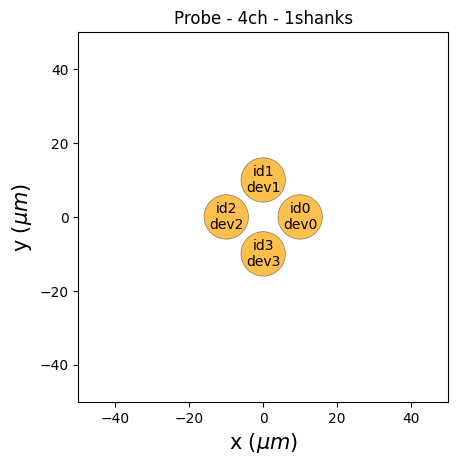

In [28]:
tetrode = pi.generate_tetrode()
tetrode.set_device_channel_indices(np.arange(4))
tetrode.set_contact_ids(np.arange(4))

pg = pi.ProbeGroup()
pg.add_probe(tetrode)
print(pg.get_global_device_channel_indices())

fig, ax2 = plt.subplots(1, 1)
plot_probe(tetrode, ax=ax2, with_device_index=True, with_contact_id=True)
plt.show()


## Find All Files for Animal

In [29]:
# Find all files
all_genotypes = [genotype]
all_genotypes.extend(genotypes_aliases[genotype_idx])
gzip_file_list = []
gzip_folder_list = []

for gtype in all_genotypes:
    gzip_file_list.extend(glob.glob(f'{bin_folder_path}/*/{animal_id}*{gtype}*.npy.gz'))
    gzip_folder_list.extend(glob.glob(f'{bin_folder_path}/{animal_id}*{gtype}*'))
gzip_file_list = list(set(gzip_file_list))
gzip_folder_list = list(set(gzip_folder_list))

gzip_file_list.sort()
gzip_folder_list.sort()

if TRUNCATE:
    warn("TRUNCATE == True. Set to False in final figure run!")
    gzip_folder_list = gzip_folder_list[::TRUNCATE_SKIP]
    gzip_file_list = [e for e in gzip_file_list if any(substring in e for substring in gzip_folder_list)]

gzip_file_names = [Path(e).name.partition('.')[0] for e in gzip_file_list]
gzip_folder_names = [PurePath(e).name for e in gzip_folder_list]

print("-"*50)
for e in gzip_file_names:
    print(e)
print("-"*50)
for e in gzip_folder_names:
    print(e)
print("-"*50)

--------------------------------------------------
1133_WT_4 half turns + 3-8th of full turn_right after turning_01-25-17
1133_WT_4 half turns + 3-8th of full turn_right after turning_01-25-17_ca1o
1133_WT_4 half turns + 3-8th of full turn_right after turning_01-25-17_ca1s
1133_WT_4 half turns + 3-8th of full turn_right after turning_01-25-17_ca3
1133_WT_5 half turns + 1-4th of full turn_after a few days_02-1-17
1133_WT_5 half turns + 1-4th of full turn_after a few days_02-1-17_ca1o
1133_WT_5 half turns + 1-4th of full turn_after a few days_02-1-17_ca1s
1133_WT_5 half turns + 1-4th of full turn_after a few days_02-1-17_ca3
1133_WT_5 half turns + 1-4th of full turn_after recovery_Day 1_night_01-26-17
1133_WT_5 half turns + 1-4th of full turn_after recovery_Day 1_night_01-26-17_ca1o
1133_WT_5 half turns + 1-4th of full turn_after recovery_Day 1_night_01-26-17_ca1s
1133_WT_5 half turns + 1-4th of full turn_after recovery_Day 1_night_01-26-17_ca3
1133_WT_5 half turns + 1-4th of full turn_a

## Sort Spikes

In [61]:
# Preprocess recording for sorting
def preprocess_recording_sorting(rec, mcorr_folder=None):
    rec_prep = rec
    rec_prep = spre.common_reference(rec_prep, dtype=np.float32)
    rec_prep = spre.scale(rec_prep, gain=10, dtype=np.float32) # Scaling for whitening to work properly
    rec_prep = spre.whiten(rec_prep, dtype=np.float32)
    rec_prep = spre.bandpass_filter(rec_prep, freq_min=freq_min, freq_max=freq_max, ftype='bessel', dtype=np.float32)
    
    if mcorr_folder is not None:
        motion_info = spre.load_motion_info(mcorr_folder)
        rec_prep = sc.motion_interpolation.interpolate_motion(
                  recording=rec_prep,
                  motion=motion_info['motion'],
                  temporal_bins=motion_info['temporal_bins'],
                  spatial_bins=motion_info['spatial_bins'],
                  **motion_info['parameters']['interpolate_motion_kwargs'])
        
    return rec_prep

# Preprocess recording for waveform extraction. Mangles the data less than preprocess_recording_sorting
def preprocess_recording_waveforms(rec):
    rec_prep = rec
    rec_prep = spre.notch_filter(rec_prep, freq=60, dtype=np.float32) # Get rid of mains hum
    rec_prep = spre.highpass_filter(rec_prep, freq_min=60, ftype='bessel', dtype=np.float32)
    # rec_prep = spre.highpass_filter(rec_prep, freq_min=60, ftype='butter', dtype=np.float32)
    
    return rec_prep

# Preprocess recording to generate motion correction info.
# Will not be used for final sorting, but you can calibrate final sorting with this motion correction info
def preprocess_recording_mcorr(rec, mcorr_folder):
    rec_prep = rec
    rec_prep = spre.common_reference(rec_prep, dtype=np.float32)
    rec_prep = spre.bandpass_filter(rec_prep, freq_min=freq_min, freq_max=freq_max, dtype=np.float32)
    rec_prep = spre.correct_motion(rec_prep, preset='nonrigid_accurate', folder=mcorr_folder)

In [69]:
# Clear up the temporary directories used for cacheing sorting
temp_folder_files = []
for gtype in all_genotypes:
    temp_folder_files.extend(glob.glob(f'{temp_folder_path.as_posix()}/{animal_id}*{gtype}**/.*', recursive=True))
    temp_folder_files.extend(glob.glob(f'{temp_folder_path.as_posix()}/{animal_id}*{gtype}**'))
temp_folder_files = list(set(temp_folder_files))

for f in temp_folder_files:
    try:
        if os.path.isfile(f) or os.path.islink(f):
            os.unlink(f)
        elif os.path.isdir(f):
            shutil.rmtree(f)
    except Exception as ex:
        print(f"Exception: {ex}")
        
# Iterate over tetrode regions
we_depths = []
num_units_depths = []
plot_file_names = []
recording_durations = []
for j, region in enumerate(tetrode_names):
    print(f'===Analyzing {region}===')
    we_depths.append([])
    num_units_depths.append([])
    plot_file_names.append([])
    
    reg_file_list = [f for f in gzip_file_list if f'{region}.npy.gz' in f]
    reg_file_names = [Path(e).name.partition('.')[0] for e in reg_file_list]
    # gzip_folder_names = [f for f in gzip_file_names]

    # Iterate over depths
    for i, e in enumerate(reg_file_list):
        
        reg_path = Path(e)
        reg_path_name = reg_path.name.partition('.')[0]
        print(reg_path_name)
        plot_file_names[-1].append(reg_path_name)

        # Set up folders
        tmpdir_path = temp_folder_path / reg_path.parent.name / reg_path_name
        os.makedirs(tmpdir_path, exist_ok=True)
        
        # Extract recording from .NPY.GZ
        with tempfile.NamedTemporaryFile(dir=reg_path.parent) as tmp:
            fcomp = gzip.GzipFile(reg_path, 'r')
            bin_arr_recov = np.load(fcomp)
            bin_arr_recov.tofile(tmp)

            recording = se.read_binary(tmp.name, sampling_frequency=f_s, dtype=np.float32, num_channels=ncol_tet, gain_to_uV=1000)
            recording = recording.set_probes(pg)
        recording_durations.append(recording.get_duration())
        
        # Preprocess recording
        # recording_prep_we = spre.bandpass_filter(recording, freq_min=100, dtype=np.float32)
        recording_prep_we = preprocess_recording_waveforms(recording)
        
        if MOTIONCORR:
            preprocess_recording_mcorr(recording, mcorr_folder=tmpdir_path / 'motion_correction') # Correct motion, but do not use motion correction output directly
            recording_preprocessed = preprocess_recording_sorting(recording, mcorr_folder=tmpdir_path / 'motion_correction') # Apply motion correction to raw data
        else:
            recording_preprocessed = preprocess_recording_sorting(recording)

        # Sort spikes
        try:
            with TemporaryDirectory(dir=tmpdir_path, prefix='temp-') as tmpdir:
                print(tmpdir)
                recording_cached = create_cached_recording(recording_preprocessed, folder=tmpdir)
                sorting = ms5.sorting_scheme2(
                    recording=recording_cached,
                    sorting_parameters=ms5.Scheme2SortingParameters(
                        phase1_detect_channel_radius=100,
                        detect_channel_radius=100,
                        snippet_T1=40,
                        snippet_T2=40,
                    )
                )
        except OSError as ex:
            print(f"OSError: {ex}")

        # Save sorting for later processing (MarshMakeStatsAndFigs.ipynb). Other SortingExtractors available
        if SAVESORT:
            directory = sort_folder_path / reg_path_name
            # if os.path.exists(dir):
            #     shutil.rmtree(dir)
            os.makedirs(directory, exist_ok=True)
            se.NpzSortingExtractor.write_sorting(sorting, directory / f"{reg_path_name}_sort")
            recording_prep_we.save_to_folder(folder=directory / f"{reg_path_name}_rec", overwrite=True)

        # If no units found, bypass waveform extraction
        if sorting.get_num_units() == 0:
            print("No units! Skipping..")
            we_depths[-1].append(None)
            num_units_depths[-1].append(None)
            continue

        # Extract waveforms from recording based on sorting
        we = si.extract_waveforms(recording=recording_prep_we, # Extract from filtered signals
                                  sorting=sorting, 
                                  folder=tmpdir_path / 'waveforms_dense', 
                                  sparse=False, 
                                  max_spikes_per_unit=None,
                                  overwrite=True,
                                  allow_unfiltered=True,
                                  ms_before=waveform_extraction_window[0],
                                  ms_after=waveform_extraction_window[1])
        we_depths[-1].append(we)
        num_units_depths[-1].append(sorting.get_num_units())
        print(we)
        
        # Calculate metrics for plotting
        # corr = spost.compute_correlograms(we)
        # pcs = spost.compute_principal_components(we)
        # amps = spost.compute_spike_amplitudes(we)
        # sloc = spost.compute_spike_locations(we, method="monopolar_triangulation")
        # tmet = spost.compute_template_metrics(we, include_multi_channel_metrics=False)
        # sim = spost.compute_template_similarity(we)
        # uloc = spost.compute_unit_locations(we, method="monopolar_triangulation")

        # Plot traces
        # widg = sw.plot_unit_waveforms_density_map(we,
        #                                           # same_axis=True,
        #                                           # use_max_channel=True,
        #                                           figsize=(10, 2.5 * sorting.get_num_units()))
        # widg.figure.suptitle("Unit Waveform Density Map")

Exception: [Errno 16] Device or resource busy: '.nfs00000007cc6514ce00009b27'
===Analyzing ca3===
1133_Exp_5 half turns + 1-4th of full turn_after recovery_Day 1_night_01-26-17_ca3
/mnt/isilon/marsh_single_unit/MarshMountainSort/temp-depthsort/1133_Exp_5 half turns + 1-4th of full turn_after recovery_Day 1_night_01-26-17/1133_Exp_5 half turns + 1-4th of full turn_after recovery_Day 1_night_01-26-17_ca3/temp-_gddqhtg


write_binary_recording: 100%|##########################| 388/388 [00:28<00:00, 13.83it/s]


Using the full recording for training: 1936.0 sec
Running phase 1 sorting
Number of channels: 4
Number of timepoints: 48400000
Sampling frequency: 25000.0 Hz
Channel 0: [10.  0.]
Channel 1: [6.123234e-16 1.000000e+01]
Channel 2: [-1.0000000e+01  1.2246468e-15]
Channel 3: [-1.8369702e-15 -1.0000000e+01]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 100
[[0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3]]

m = 0 (nbhd size: 4)
m = 1 (nbhd size: 4)
m = 2 (nbhd size: 4)
m = 3 (nbhd size: 4)
Detected 903 spikes
*** MS5 Elapsed time for detect_spikes: 4.620 seconds ***
Removing duplicate times
*** MS5 Elapsed time for remove_duplicate_times: 0.001 seconds ***
Extracting 903 snippets
*** MS5 Elapsed time for extract_snippets: 0.004 seconds ***
Computing PCA features with npca=12
*** MS5 Elapsed time for compute_pca_features: 0.092 seconds ***
Isosplit6 clustering with npca_per_subdivision=10
Found 2

write_binary_recording: 100%|########################| 1936/1936 [00:27<00:00, 71.44it/s]


Setting 'return_scaled' to False


extract waveforms memmap multi buffer: 100%|########| 1936/1936 [00:04<00:00, 479.23it/s]


WaveformExtractor: 4 channels - 2 units - 1 segments
  before:50 after:100 n_per_units:None
===Analyzing ca1s===
1133_Exp_5 half turns + 1-4th of full turn_after recovery_Day 1_night_01-26-17_ca1s
/mnt/isilon/marsh_single_unit/MarshMountainSort/temp-depthsort/1133_Exp_5 half turns + 1-4th of full turn_after recovery_Day 1_night_01-26-17/1133_Exp_5 half turns + 1-4th of full turn_after recovery_Day 1_night_01-26-17_ca1s/temp-q0wvcaao


write_binary_recording: 100%|##########################| 388/388 [00:30<00:00, 12.68it/s]


Using the full recording for training: 1936.0 sec
Running phase 1 sorting
Number of channels: 4
Number of timepoints: 48400000
Sampling frequency: 25000.0 Hz
Channel 0: [10.  0.]
Channel 1: [6.123234e-16 1.000000e+01]
Channel 2: [-1.0000000e+01  1.2246468e-15]
Channel 3: [-1.8369702e-15 -1.0000000e+01]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 100
[[0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3]]

m = 0 (nbhd size: 4)
m = 1 (nbhd size: 4)
m = 2 (nbhd size: 4)
m = 3 (nbhd size: 4)
Detected 0 spikes
*** MS5 Elapsed time for detect_spikes: 2.675 seconds ***
Removing duplicate times
*** MS5 Elapsed time for remove_duplicate_times: 0.000 seconds ***
Extracting 0 snippets
*** MS5 Elapsed time for extract_snippets: 0.000 seconds ***
Computing PCA features with npca=12
*** MS5 Elapsed time for compute_pca_features: 0.000 seconds ***
Isosplit6 clustering with npca_per_subdivision=10
Found 0 clu

write_binary_recording: 100%|########################| 1936/1936 [00:33<00:00, 57.72it/s]


No units! Skipping..
===Analyzing ca1o===
1133_Exp_5 half turns + 1-4th of full turn_after recovery_Day 1_night_01-26-17_ca1o
/mnt/isilon/marsh_single_unit/MarshMountainSort/temp-depthsort/1133_Exp_5 half turns + 1-4th of full turn_after recovery_Day 1_night_01-26-17/1133_Exp_5 half turns + 1-4th of full turn_after recovery_Day 1_night_01-26-17_ca1o/temp-80f09qz0


write_binary_recording: 100%|##########################| 388/388 [00:29<00:00, 13.30it/s]


Using the full recording for training: 1936.0 sec
Running phase 1 sorting
Number of channels: 4
Number of timepoints: 48400000
Sampling frequency: 25000.0 Hz
Channel 0: [10.  0.]
Channel 1: [6.123234e-16 1.000000e+01]
Channel 2: [-1.0000000e+01  1.2246468e-15]
Channel 3: [-1.8369702e-15 -1.0000000e+01]
Loading traces
*** MS5 Elapsed time for load_traces: 0.000 seconds ***
Detecting spikes

Adjacency for detect spikes with channel radius 100
[[0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3]]

m = 0 (nbhd size: 4)
m = 1 (nbhd size: 4)
m = 2 (nbhd size: 4)
m = 3 (nbhd size: 4)
Detected 5934 spikes
*** MS5 Elapsed time for detect_spikes: 0.786 seconds ***
Removing duplicate times
*** MS5 Elapsed time for remove_duplicate_times: 0.000 seconds ***
Extracting 5934 snippets
*** MS5 Elapsed time for extract_snippets: 0.024 seconds ***
Computing PCA features with npca=12
*** MS5 Elapsed time for compute_pca_features: 0.103 seconds ***
Isosplit6 clustering with npca_per_subdivision=10
Found

write_binary_recording: 100%|########################| 1936/1936 [00:23<00:00, 81.50it/s]


Setting 'return_scaled' to False


extract waveforms memmap multi buffer: 100%|########| 1936/1936 [00:13<00:00, 146.80it/s]

WaveformExtractor: 4 channels - 2 units - 1 segments
  before:50 after:100 n_per_units:None


## Visualize Units by Depth + Region In 1 Animal

[[2], [None], [2]]
[1936.0, 1936.0, 1936.0]
[WaveformExtractor: 4 channels - 2 units - 1 segments
  before:50 after:100 n_per_units:None]


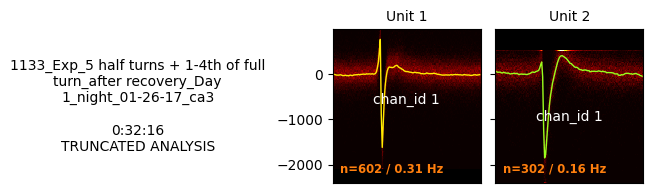

[None]
No units in region ca1s, skipping..
/mnt/isilon/marsh_single_unit/MarshMountainSort/output-depthsort/1133_Exp_ca1s-maxch
[WaveformExtractor: 4 channels - 2 units - 1 segments
  before:50 after:100 n_per_units:None]


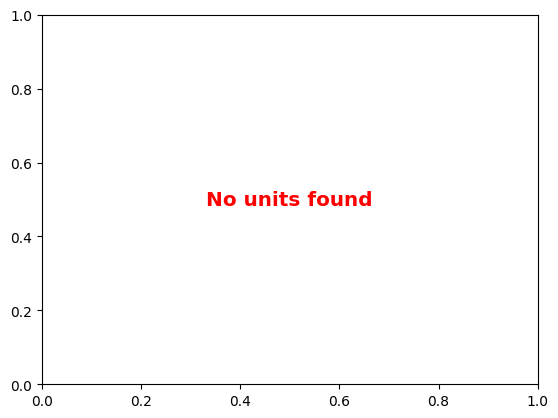

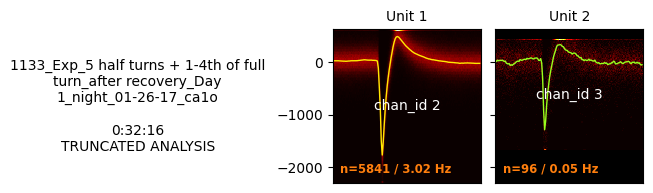

In [70]:
# print(we_depths)
print(num_units_depths)
print(recording_durations)
# print(plot_file_names)

# Iterate over regions
for i, we_region in enumerate(we_depths):
    print(we_region)

    if len([e for e in num_units_depths[i] if e is not None]) == 0:
        print(f"No units in region {tetrode_names[i]}, skipping..")

        # Report no units found in region
        plt.text(0.5, 0.5, "No units found", ha='center', va='center', fontsize='x-large', c='red', fontweight='bold')
        savefig_path = output_folder_path / f'{animal_id}_{genotype}_{tetrode_names[i]}-maxch'
        if MOTIONCORR:
            savefig_path = f'{savefig_path}-mcorr'
        print(savefig_path)
        plt.savefig(savefig_path, bbox_inches='tight', dpi=300)
        
        continue
    
    num_units_max = max(filter(None, num_units_depths[i]))
    num_depths = len(we_region)
    
    fig, ax = plt.subplots(num_depths, num_units_max, figsize=(2*num_units_max, 2*num_depths), sharey=True, sharex=True, squeeze=False)
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    
    # Iterate over depths
    for j, we in enumerate(we_region):
        if we is None:
            for k in range(1, num_units_max):
                ax[j, k].set_axis_off()
            ax[j, 0].text(0.5, 0.5, "No units", transform=ax[j,0].transAxes, ha='center', va='center', fontsize='x-large', c='red', fontweight='bold')
            continue
        # Iterate over units
        for k in range(num_units_depths[i][j]):
            sw.plot_unit_waveforms_density_map(we, use_max_channel=True, unit_ids=[we.unit_ids[k]], ax=ax[j, k])
            ax[j, k].set_title(f"Unit {we.unit_ids[k]}", fontsize='medium')
            num_spikes = len(we.get_sampled_indices(we.unit_ids[k]))
            ax[j, k].text(0.05, 0.05, f"n={num_spikes} / {round(num_spikes/we.get_total_duration(), 2)} Hz", 
                          transform=ax[j, k].transAxes, 
                          ha='left', va='bottom', c='C1', fontsize='small', fontweight='bold')
            ax[j, k].set_ylabel("")
            ax[j, k].set_facecolor('black')
        for k in range(num_units_depths[i][j], num_units_max):
            ax[j, k].set_axis_off()
            
    for j, we in enumerate(we_region):
        recording_duration = str(datetime.timedelta(seconds=recording_durations[j]))
        if TRUNCATE:
            recording_duration += "\nTRUNCATED ANALYSIS"
        ylabel_text = '\n'.join(wrap(plot_file_names[i][j], 40))
        ax[j, 0].set_ylabel(f"{ylabel_text}\n\n{recording_duration}", rotation=0, labelpad=100, va='center')
        
    if SAVEFIGS:
        savefig_path = output_folder_path / f'{animal_id}_{genotype}_{tetrode_names[i]}-maxch'
        if MOTIONCORR:
            savefig_path = f'{savefig_path}-mcorr'
        print(savefig_path)
        plt.savefig(savefig_path, bbox_inches='tight', dpi=300)
    plt.show()
    
    
# widg = sw.plot_unit_waveforms_density_map(we,
#                                           # same_axis=True,
#                                           # use_max_channel=True,
#                                           figsize=(10, 2.5 * sorting.get_num_units()))
# widg.figure.suptitle("Unit Waveform Density Map")

    

## Save Sorting to CSVs

In [9]:
# Get dictionary from .XLSX file
df = pd.read_excel(base_folder_path / excel_name, sheet_name)
fname_dict = df.set_index('Filename').to_dict()['Halfturns']
# depths = list(set(fname_dict.values())).sort()
depths = list(set(fname_dict.values()))
depths.sort()
depths_dict = dict(zip(depths, np.arange(len(depths))))

print(depths)

[0.0, 1.0, 2.0, 3.0, 3.5, 4.0, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.5]


In [72]:
# Generate CSV files
if SAVEFIGS:
    for i, region in enumerate(tetrode_names):
        for j, filename in enumerate(gzip_folder_names): # Should be the same across all regions. Excludes region data
            # print(region, filename)
            csv_name = f"{animal_id}_{genotype}_{region}_{str(fname_dict[filename]).replace('.', '-')}"
            csv_data = []
            print(csv_name)
    
            with open(output_csv_folder_path / f"{csv_name}.csv", 'w') as f:
                we = we_depths[i][j]
                we_csvunits = []

                if we is not None:
                    we_unittochannel = si.get_template_extremum_channel(we, outputs="index")
                    we_spiketrain = we.sorting.to_spike_vector(concatenated=True).tolist()
                    we_spiketrain = np.array([*we_spiketrain])
                    
                    # Grab all units from sorting and isolate strongest channel for each unit
                    for unit_id in we.unit_ids:
                        we_waveforms = we.get_waveforms(unit_id,
                                                        force_dense=True,
                                                        lazy=False)
                        we_waveforms = we_waveforms[:, :, we_unittochannel[unit_id]]
                        mask = np.isin(we_spiketrain[:, 1], test_elements=we.sorting.id_to_index(unit_id))
                        we_unit_spiketrain = we_spiketrain[mask][:, 0]
        
                        csv_data.append(np.concatenate((np.full((we_waveforms.shape[0], 1), unit_id),
                                                        we_unit_spiketrain.reshape(-1, 1),
                                                        we_waveforms), axis=1))
                
                # Write to CSV
                csvwriter = csv.writer(f)
                csvwriter.writerow([animal_id, genotype, region, fname_dict[filename]])
                csvwriter.writerow([filename])
                if we is not None:
                    csvwriter.writerow([we.get_total_duration(), we.get_total_samples(), f_s])
                    for d in csv_data:
                        csvwriter.writerows(d)
                else:
                    print(f"Empty waveform extractor for: {filename}. Skipping write to CSV..")
            